# DNA Damage model formation & Prediction

In [764]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
import pycytominer
from pycytominer.consensus import modz
np.random.seed(42)
random.seed(42)

In [737]:
warnings.filterwarnings(action = 'ignore')

## 1. Preparing Cell Painting Data & Cell Health Data

### Load IDR-0080 Data & Cell Health Data
### Reference : https://pubmed.ncbi.nlm.nih.gov/33534641/

In [739]:
x_df = pd.read_csv('cell_painting_modz.tsv', sep = '\t')
x_meta = x_df.iloc[:, :3]
x_df = x_df.iloc[:, 3:]

y_all_df = pd.read_csv('cell_health_modz.tsv', sep = '\t')
y_df = y_all_df['cc_all_n_spots_h2ax_per_nucleus_area_mean']

### Load Chemical Annotation Data
### Reference : https://gigadb.org/dataset/100351

In [740]:
# Chemical annotation 
chem_dat = pd.read_csv('chemical_annotations.csv')
chem_dat

,BROAD_ID,CPD_NAME,CPD_NAME_TYPE,CPD_SAMPLE_ID,DOS_LIBRARY,SOURCE_NAME,CHEMIST_NAME,VENDOR_CATALOG_ID,CPD_SMILES,USERCOMMENT
0,BRD-A56675431-001-04-0,altizide,INN,SA82748,NaN,Prestwick Chemical Inc.,NaN,Prestw-721,NS(=O)(=O)c1cc2c(NC(CSCC=C)NS2(=O)=O)cc1Cl,NaN
1,BRD-A51829654-001-01-4,"BRL-15,572",common,SA82481,NaN,Biomol International Inc.,NaN,AC-536,OC(CN1CCN(CC1)c1cccc(Cl)c1)C(c1ccccc1)c1ccccc1,NaN
2,BRD-K04046242-001-03-6,equilin,primary-common,SA82922,NaN,Prestwick Chemical Inc.,NaN,Prestw-850,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc34)[C@@H]1CCC2=O,NaN
3,BRD-K16508793-001-01-8,diazepam,INN,SA59660,NaN,MicroSource Discovery Systems Inc.,NaN,1900003,CN1c2ccc(Cl)cc2C(=NCC1=O)c1ccccc1,NaN
4,BRD-K09397065-001-01-6,SR 57227A,to-be-curated,SA82504,NaN,Biomol International Inc.,NaN,AC-561,NC1CCN(CC1)c1cccc(Cl)n1,NaN
...,...,...,...,...,...,...,...,...,...,...
30611,BRD-K47092271-001-01-7,BRD-K47092271,BROAD_CPD_ID,SA799574,Benzofuran Library,Broad Institute of MIT and Harvard,NaN,NaN,COCC(=O)Nc1ccc2O[C@@H]3[C@@H](C[C@H](CC(=O)NCC...,NaN
30612,BRD-K30358777-001-01-0,BRD-K30358777,BROAD_CPD_ID,SA800605,Benzofuran Library,Broad Institute of MIT and Harvard,NaN,NaN,COc1ccc(CNC(=O)C[C@@H]2C[C@H]3[C@H](Oc4ccc(NC(...,NaN
30613,BRD-K32423836-001-01-9,BRD-K32423836,BROAD_CPD_ID,SA799806,Benzofuran Library,Broad Institute of MIT and Harvard,NaN,NaN,COCCNC(=O)C[C@H]1C[C@@H]2[C@@H](Oc3ccc(NC(=O)C...,NaN
30614,BRD-K28250273-001-01-2,BRD-K28250273,BROAD_CPD_ID,SA1482018,Azetidine Nitrile Full Library,Broad Institute of MIT and Harvard,NaN,NaN,OC[C@H]1[C@H]([C@H](C#N)N1C(=O)Nc1cccc(F)c1)c1...,NaN


# 2. Validation dataset preprocessing

## Load sample validation dataset 
### cpg0012's plate 24306
### Reference : https://gigadb.org/dataset/100351

In [741]:
# Load validation datasets
x_val_dat = pd.read_csv('mean_well_profiles.csv') # plate 24306


# Follow idr0080 normalization ways
x_val_norm_dat = pycytominer.normalize(
    profiles = x_val_dat,
    features = 'infer',
    method = 'mad_robustize',
    samples = 'Metadata_solvent == "DMSO"'
)

# Follow idr0080 feature selection ways
x_val_norm_dat = pycytominer.feature_select(
    profiles = x_val_norm_dat,
    features = 'infer',
    operation = [
        'drop_na_columns',
        'blocklist',
        'variance_threshold',
        'drop_outliers'
    ]
)

#x_val_norm_dat = x_val_norm_dat.query('Metadata_broad_sample != "DMSO"')

# Devied metadata & cell painting data
x_val_meta = x_val_norm_dat.iloc[:, :17] # 17 
x_val_df = x_val_norm_dat.iloc[:, 17:] 

In [742]:
# MODZ scaling for validaiton dataset
x_val_df['Metadata_broad_sample'] = x_val_meta['Metadata_broad_sample']

x_df_modz = modz(
    x_val_df,
    replicate_columns = ['Metadata_broad_sample'],
    precision = 5
)

x_df_modz = x_df_modz.iloc[:, 1:]
x_df_modz

,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MaximumRadius,Cells_AreaShape_MeanRadius,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,0.077826,2.210831,3.185245,2.351784,-3.453662,-0.665763,2.294685,2.477498,1.116056,1.192810,...,0.435456,-0.910246,-1.267630,-1.214799,0.464848,-0.088872,-0.077549,-0.979193,-1.388224,-1.092092
1,-1.037678,0.374717,0.508243,0.848381,0.469262,-0.761764,1.928568,1.955454,2.084137,2.281973,...,5.037798,-0.585354,0.822544,0.237205,1.613462,1.588054,1.555721,2.031896,1.292912,1.353086
2,-0.674491,-2.435661,-0.209134,0.255651,0.427650,0.870017,0.800537,0.798476,1.133007,1.396999,...,4.899822,-0.405544,0.373237,-0.185714,0.569231,1.374408,1.334015,1.174123,1.451945,1.272649
3,-0.882026,0.449661,2.906479,1.862581,-1.666906,0.203821,2.207463,2.244937,1.318162,1.334734,...,-0.044538,-0.601456,-0.323971,-0.541390,-0.374285,-0.487961,-0.348521,0.966598,0.823093,0.800769
4,-0.207536,-0.711962,1.603780,1.146239,-1.648947,-0.455139,1.295874,1.436188,0.650590,0.709270,...,0.316370,0.305549,0.588692,0.481053,-1.098381,-1.340394,-1.475020,0.173596,-0.069845,0.161734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,1.608401,-0.674491,1.199265,1.494756,-0.931037,-0.626963,0.706344,0.685465,0.223367,0.200746,...,-0.790790,-0.754632,-0.827323,-0.692013,-1.255622,-0.468507,-0.699628,0.675044,-0.038565,0.393632
317,1.348982,-0.149887,1.596471,1.353023,-1.611648,-0.813942,0.333514,0.401696,-0.387185,-0.148372,...,-0.629000,-0.474736,-0.581660,-0.587504,-0.688760,-0.689443,-0.873527,-0.253329,-0.218745,-0.134691
318,-0.752317,1.648755,1.083539,0.337857,-1.263909,-0.239567,0.442785,0.395045,0.077920,0.124410,...,-1.282379,0.023325,-0.190828,-0.128193,-1.201422,-0.945536,-0.872981,-0.399807,0.066885,0.031387
319,-1.193330,-0.149887,0.492029,0.395970,-0.860426,-2.234476,0.239986,0.167619,-0.406153,-0.288282,...,-0.432186,-0.232994,-0.361480,-0.427102,-1.253156,-0.619239,-0.444032,-0.350578,-0.635276,-0.625096


In [743]:
# Check unique compound in validation dataset
compound = x_val_meta['Metadata_broad_sample'].unique()
len(compound)

321

# 3. Setting same x features number for x data & validation data 

In [744]:
# Filter except same features in idr0080 & cpg0012
x_cols = x_df.columns
x_val_cols = x_df_modz.columns

filt_cols = x_cols.intersection(x_val_cols)

x_df = x_df[filt_cols]
x_val_df = x_df_modz[filt_cols]

display(x_df)
display(x_val_df)

,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_3,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_ER_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_AGP_5_0,Nuclei_Texture_SumVariance_DNA_10_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_AGP_5_0,Nuclei_Texture_Variance_DNA_10_0,Nuclei_Texture_Variance_DNA_5_0
0,-0.180160,-0.155631,0.014646,0.188053,1.231056,0.031064,-0.585477,0.467976,0.254203,0.129446,...,0.882859,0.841687,0.339831,0.562585,0.879950,0.904785,0.923143,0.944998,0.984938,0.961945
1,0.370572,-0.247842,-0.030773,0.433778,0.062456,0.266860,0.838679,-0.467417,0.340793,-0.024450,...,0.513820,0.344554,0.134318,0.018933,0.359496,0.557998,0.504751,0.407462,0.522251,0.519441
2,-0.360905,0.794740,0.743296,-0.438752,0.827288,-0.728499,-0.422394,-0.147624,0.083870,-0.160722,...,-0.456539,0.373750,-0.111184,-0.042733,-0.840771,-0.536215,-0.497296,-0.748232,-0.515240,-0.526734
3,0.262450,0.480421,0.821096,-0.337898,0.054479,-0.662314,0.067979,0.025010,0.158138,-0.342062,...,0.115466,0.186411,0.249292,0.688435,-0.521766,0.124801,0.063444,-0.560178,-0.062851,0.026056
4,-0.110264,-0.074895,0.569377,0.571678,0.976504,-1.111947,1.348542,0.584906,-3.128483,-2.324773,...,0.154802,2.975785,1.128414,-0.638839,0.753884,0.808944,0.594059,0.674015,0.140325,0.417465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.446930,0.247953,0.331462,-0.228694,0.648857,-0.394799,-0.477804,-0.203016,0.387554,0.485502,...,0.305814,0.952718,0.697652,0.087784,0.266722,0.254346,0.367875,0.191115,0.220894,0.257950
353,-0.500081,1.455427,1.153796,-1.395398,1.167778,-1.413069,-0.684198,-0.923160,-0.145706,-0.535382,...,-0.207834,-0.280317,-0.422648,-0.763835,-0.254697,-0.380000,-0.404530,-0.266026,-0.341998,-0.287431
354,0.407771,0.719510,0.691270,-0.999921,0.701489,-0.965601,-0.937154,-0.218680,0.145943,-0.149745,...,0.011171,-0.575574,-0.272102,-0.101586,-0.117305,-0.083261,-0.085342,-0.213054,-0.126822,-0.101668
355,0.063720,-0.255658,0.075113,0.999995,0.251456,0.237111,0.342004,0.084765,0.957639,-0.562746,...,0.766721,0.518347,1.450779,1.421830,1.483743,0.639279,0.614153,1.624128,0.523767,0.603819


,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_3,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_ER_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_AGP_5_0,Nuclei_Texture_SumVariance_DNA_10_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_AGP_5_0,Nuclei_Texture_Variance_DNA_10_0,Nuclei_Texture_Variance_DNA_5_0
0,2.210831,3.185245,2.351784,-3.453662,-0.725301,-3.038433,-1.452215,-2.490358,0.215098,-1.662977,...,0.198737,0.034115,-0.401413,-0.824950,-1.672145,0.149615,0.237127,-1.458522,0.694766,0.435456
1,0.374717,0.508243,0.848381,0.469262,-1.271219,-0.539449,0.406587,-0.023074,1.652274,-0.640034,...,4.425595,2.762427,2.268049,2.408099,0.904769,5.415348,5.487572,-0.283376,5.591977,5.037798
2,-2.435661,-0.209134,0.255651,0.427650,-2.686150,-0.130634,1.142348,0.456705,-0.323134,0.581353,...,4.648500,3.087588,2.152137,2.091563,1.593579,4.659855,5.262547,0.421885,5.430637,4.899822
3,0.449661,2.906479,1.862581,-1.666906,-0.824188,-2.302488,-1.109963,-2.943595,-0.220954,-0.420657,...,-0.154235,-0.377437,-0.067547,0.259038,-1.086147,0.141180,0.004284,-1.786379,0.134911,-0.044538
4,-0.711962,1.603780,1.146239,-1.648947,0.842747,-1.575018,-1.207895,-1.349442,0.750506,0.339709,...,-0.282950,0.060413,-0.860123,-1.068675,-1.294816,-0.047170,0.130027,-1.514355,0.615017,0.316370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,-0.674491,1.199265,1.494756,-0.931037,-0.994754,-0.898056,-1.352128,-0.530739,0.970324,-1.629309,...,-1.003564,-0.769914,-0.233639,-0.071734,-1.620532,-1.711346,-1.231005,-1.975245,-0.534774,-0.790790
317,-0.149887,1.596471,1.353023,-1.611648,0.717217,-1.335799,-0.802091,-1.559356,-0.381397,-1.169557,...,-0.524293,-0.705811,0.039353,-0.107175,-1.225908,-0.488064,-0.456405,-1.429988,-0.598059,-0.629000
318,1.648755,1.083539,0.337857,-1.263909,-0.350779,-0.783795,0.771543,-1.129389,-0.967943,0.542581,...,-0.846619,-0.021072,-0.366242,-0.222260,-0.555017,-0.321643,-0.682356,-0.694217,-1.332090,-1.282379
319,-0.149887,0.492029,0.395970,-0.860426,-1.197453,-0.479067,-0.033196,-0.507453,0.343849,0.108738,...,-0.108487,-0.024398,0.141070,0.016915,-0.582637,0.489818,0.167522,-1.160208,-0.503925,-0.432186


# 4. Regression Model Formation & Accuracy Check

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor


# Data Split
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size = 0.3, random_state = 42)

# Data Flatten
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Various Regression Models
models = {
    'Linear Regression' : LinearRegression(),
    'Ridge Regression' : Ridge(),
    'Lasso Regression' : Lasso(),
    'Decision Tree Regressor' : DecisionTreeRegressor(),
    'Random Forest Regressor' : RandomForestRegressor(),
    'Gradient Boosting Regressor' : GradientBoostingRegressor(),
    'Support Vector Regressor' : SVR(),
    'K-Nearest Neighbors Regressor' : KNeighborsRegressor(),
    'Bayesian Ridge' : BayesianRidge(),
    'Elastic Net' : ElasticNet(),
    'AdaBoost Regressor' : AdaBoostRegressor(),
    'MLP Regressor' : MLPRegressor(),
    'XGBoost Regressor' : XGBRegressor(),
    'LightGBM Regressor' : LGBMRegressor()
}



# Parameter grids for linear models and tree-based models
linear_param_grids = {
    'Ridge Regression' : {'alpha' : [0.1, 1.0, 10.0, 100.0]},
    'Lasso Regression' : {'alpha' : [0.1, 1.0, 10.0, 100.0]},
    'Support Vector Regression' : {'C' : [0.1, 1.0, 10.0], 'epsilon' : [0.01, 0.1, 1]},
    'K-Nearest Neighbors Regressor' : {'n_neighbors' : [3, 5, 7, 9]},
    'Bayesian Ridge' : {},
    'Elastic Net' : {'alpha' : [0.1, 1.0, 10.0], 'l1_ratio' : [0.1, 0.5, 0.9]}
}

tree_param_grids = {
    'Decision Tree Regressor' : {'max_depth' : [None, 10, 20, 30]},
    'Random Forest Regressor' : {'n_estimators' : [100, 200, 300], 'max_depth' : [None, 10, 20]},
    'Gradient Boosting Regressor' : {'n_estimators' : [50, 100, 200], 'learning_rate' : [0.01, 0.1, 0.2]},
    'AdaBoost Regressor' : {'n_estimators' : [50, 100, 200], 'learning_rate' : [0.01, 0.1, 1.0]},
    'MLP Regressor' : {'hidden_layer_sizes' : [(50,), (100,), (50, 50)], 'alpha' : [0.0001, 0.001, 0.01]},
    'XGBoost Regressor' : {'n_estimators' : [50, 100, 200], 'learning_rate' : [0.01, 0.1, 0.2]},
    'LightGBM Regressor' : {'n_estimators' : [50, 100, 200], 'learning_rate' : [0.01, 0.1, 0.2]}
}


# Results Save
best_models = {}
best_params = {}

# Model Class dict
model_classes = {
    'Ridge Regression' : Ridge,
    'Lasso Regression' : Lasso,
    'Support Vector Regression' : SVR,
    'K-Nearest Neighbors Regressor' : KNeighborsRegressor,
    'Decision Tree Regressor' : DecisionTreeRegressor,
    'Random Forest Regressor' : RandomForestRegressor,
    'Gradient Boosting Regressor' : GradientBoostingRegressor,
    'Bayesian Ridge' : BayesianRidge,
    'Elastic Net' : ElasticNet,
    'AdaBoost Regressor' : AdaBoostRegressor,
    'MLP Regressor' : MLPRegressor,
    'XGBoost Regressor' : XGBRegressor,
    'LightGBM Regressor' : LGBMRegressor    
}

# GridSearchCV and training loop for linear models
for model_name, param_grid in linear_param_grids.items():
    model = model_classes[model_name]()
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'r2')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_


    y_pred = grid_search.best_estimator_.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'{model_name} Best Parameters: {grid_search.best_params_}')
    print(f'{model_name} (After tuning):')
    print(f'  Mean Squared Error = {mse}')
    print(f'  Root Mean Squared Error = {rmse}')
    print(f'  R² Score = {r2}\n')

# GridSearchCV and training loop for tree-based models
for model_name, param_grid in tree_param_grids.items():
    model = model_classes[model_name]()
    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, scoring = 'r2')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    best_params[model_name] = grid_search.best_params_

    y_pred = grid_search.best_estimator_.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'{model_name} Best Parameteres: {grid_search.best_params_}')
    print(f'{model_name} (After tuning):')
    print(f'  Mean Squared Error = {mse}')
    print(f'  Root Mean Squared Error = {rmse}')
    print(f'  R² Score = {r2}\n')



# Output the best parameters & r2 score for each model
print('Best parameters:')
for model_name, params in best_params.items():
    print(f'{model_name} : {params}')

Ridge Regression Best Parameters: {'alpha': 100.0}
Ridge Regression (After tuning):
  Mean Squared Error = 0.39418017347642287
  Root Mean Squared Error = 0.6278376967628042
  R² Score = 0.36172626804704544

Lasso Regression Best Parameters: {'alpha': 0.1}
Lasso Regression (After tuning):
  Mean Squared Error = 0.4812989114120691
  Root Mean Squared Error = 0.6937570982786908
  R² Score = 0.22065980725879797

Support Vector Regression Best Parameters: {'C': 10.0, 'epsilon': 0.01}
Support Vector Regression (After tuning):
  Mean Squared Error = 0.4549467894950502
  Root Mean Squared Error = 0.6744974347579464
  R² Score = 0.2633303126079488

K-Nearest Neighbors Regressor Best Parameters: {'n_neighbors': 7}
K-Nearest Neighbors Regressor (After tuning):
  Mean Squared Error = 0.5054507395466634
  Root Mean Squared Error = 0.7109505886815647
  R² Score = 0.1815521135841035

Bayesian Ridge Best Parameters: {}
Bayesian Ridge (After tuning):
  Mean Squared Error = 0.39355583829473795
  Root M

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[LightGBM] [Info] Start training from score 0.191665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Regression Results

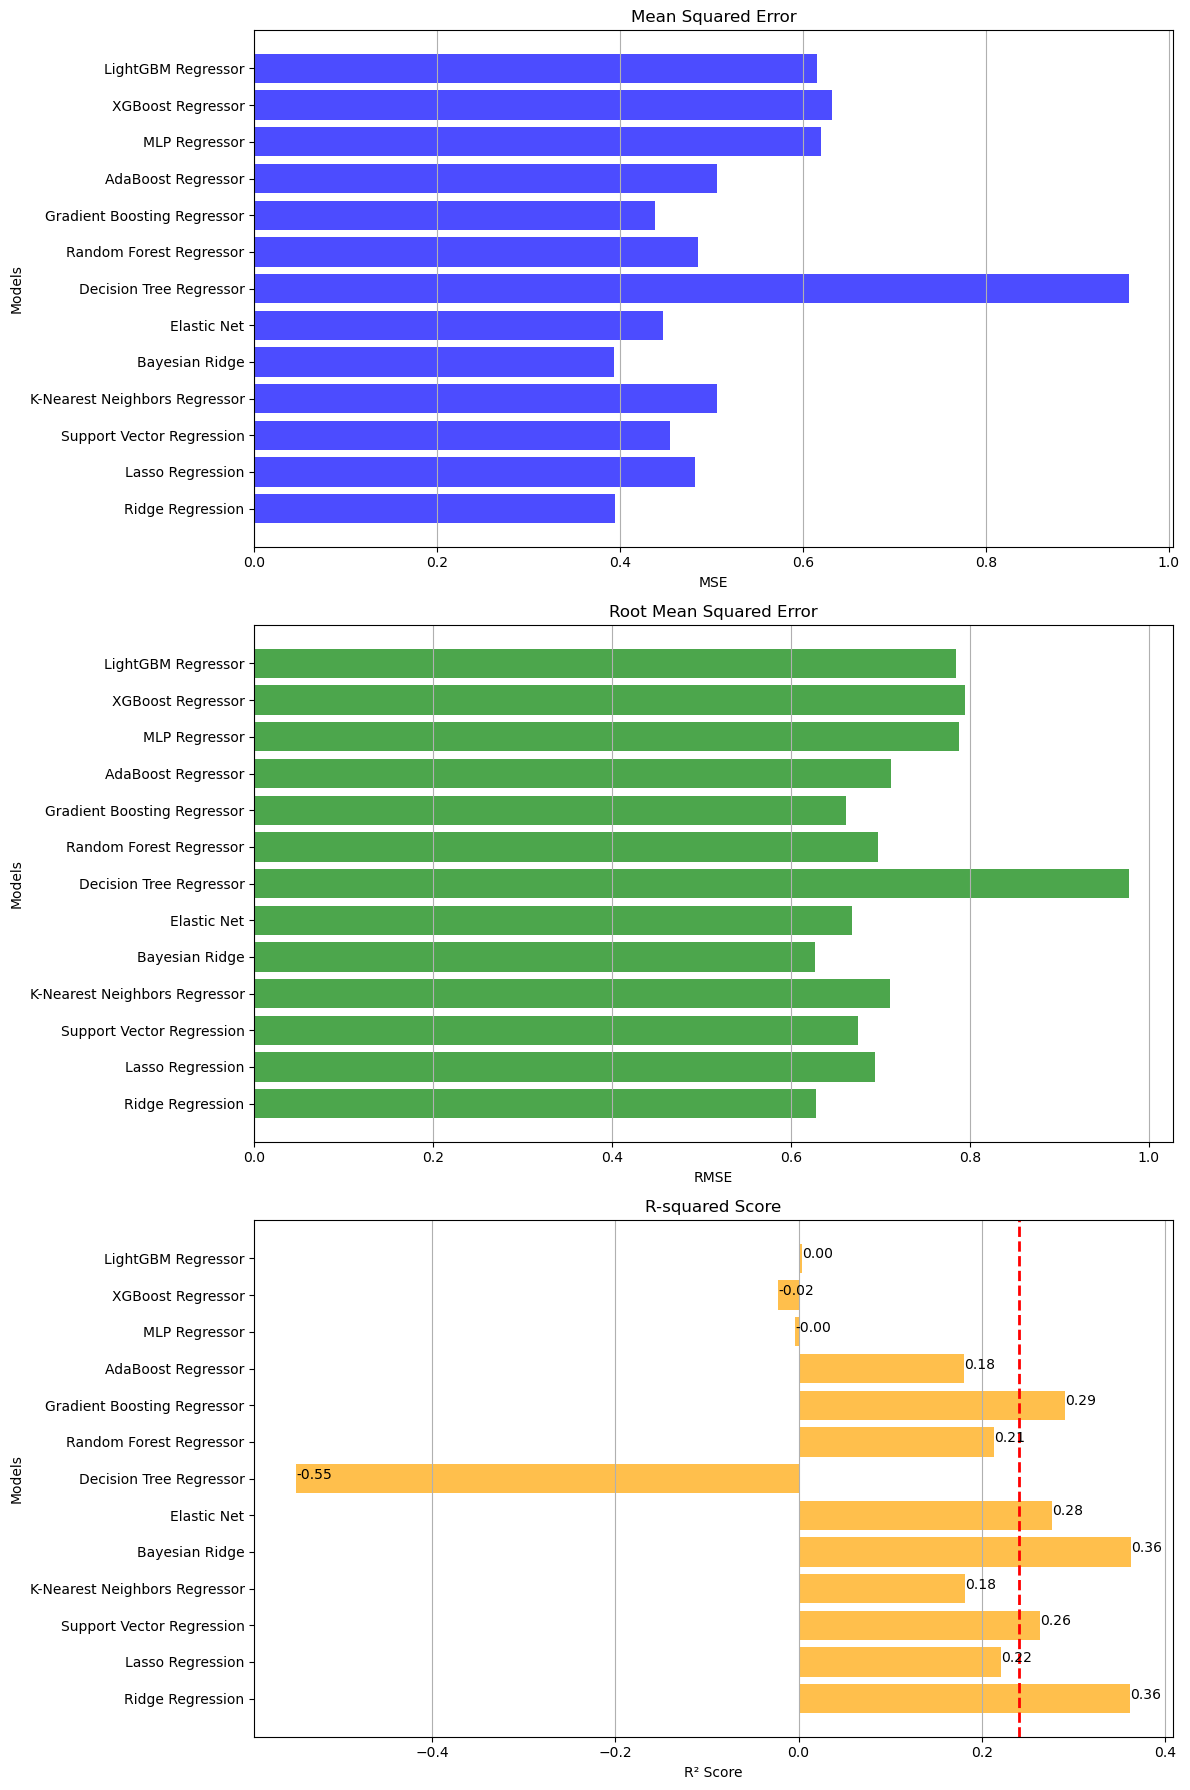

In [456]:
# Initialize lists to store evaluation metrics
model_names = []
mse_scores = []
rmse_scores = []
r2_scores = []


# Evaluate and collect scores for each model
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)


    # Valculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store scores and model names
    model_names.append(model_name)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)


# Plotting the scores
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))


# Mean Squared Error plot
ax1.barh(model_names, mse_scores, color='blue', alpha=0.7)
ax1.set_title('Mean Squared Error')
ax1.set_xlabel('MSE')
ax1.set_ylabel('Models')
ax1.xaxis.grid(True)

# Root Mean Squared Error plot
ax2.barh(model_names, rmse_scores, color='green', alpha=0.7)
ax2.set_title('Root Mean Squared Error')
ax2.set_xlabel('RMSE')
ax2.set_ylabel('Models')
ax2.xaxis.grid(True)

# R-squared plot
ax3.barh(model_names, r2_scores, color='orange', alpha=0.7)
for model_name, scores in zip(model_names, r2_scores):
    ax3.text(scores, model_name, f'{scores:.2f}')
ax3.set_title('R-squared Score')
ax3.set_xlabel('R² Score')
ax3.set_ylabel('Models')
ax3.axvline(x = 0.24, color = 'red', linestyle = '--', linewidth = 2)
ax3.xaxis.grid(True)

plt.tight_layout()
plt.savefig('accuracy_results.png')
plt.show()

# 5. Cell Health Labeling for Classification Model

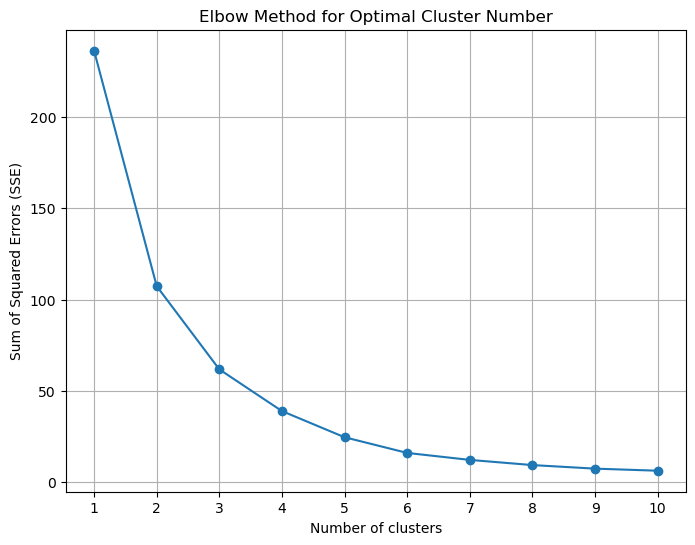

In [745]:
from sklearn.cluster import KMeans

# Create an array to store SSE values for different cluster numbers
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(y_df.values.reshape(-1, 1))
    sse.append(kmeans.inertia_)


# Plotting the elbow curve
plt.figure(figsize = (8,6))
plt.plot(range(1, 11), sse, marker = 'o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.savefig('Elbow Method.png')
plt.show()

In [746]:
# y_df Categorized

kmeans = KMeans(n_clusters = 6, random_state = 42)
y_clusters = kmeans.fit_predict(y_df.values.reshape(-1, 1))

y_df_binarized = y_clusters

In [747]:
from collections import Counter

Counter(y_df_binarized)

Counter({0: 117, 3: 94, 5: 90, 2: 38, 1: 13, 4: 5})

In [748]:
np.where(y_df_binarized == 5)

(array([  1,   2,   5,   7,   9,  15,  22,  24,  25,  28,  32,  40,  41,
         43,  53,  55,  57,  58,  59,  66,  67,  82,  87,  90,  94,  96,
         98, 107, 111, 112, 113, 124, 126, 128, 133, 134, 136, 143, 152,
        165, 169, 171, 172, 173, 176, 185, 187, 194, 195, 197, 198, 199,
        201, 209, 213, 222, 230, 235, 238, 242, 244, 246, 247, 261, 262,
        265, 270, 281, 285, 289, 290, 292, 293, 294, 295, 302, 307, 316,
        317, 318, 323, 325, 326, 328, 333, 334, 339, 340, 343, 351],
       dtype=int64),)

In [632]:
#y_df.sort_values(ascending = False).to_excel('y_df.xlsx')

In [749]:
# Remapping
mapping = {4: 0, 0: 0, 3: 0, 5: 0, 2: 1, 1: 1} # 0 : Low, 1: High
y_df_binarized = np.vectorize(mapping.get)(y_df_binarized)

In [751]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [752]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df_binarized, test_size = 0.3, random_state = 42)

# Data Flatten
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)


# 6. Classification Model Formation & Check Accuracy

In [509]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Models Dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SGDClassifier': SGDClassifier(random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# models parameters setting
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1','l2']
    },
    'SGDClassifier': {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty': ['l1', 'l2']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'GaussianNB': {}, 
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
}

# Best Parameter searching
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Show Best Parameters
    print(f"Best Parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"Best Cross-validation Accuracy for {model_name}: {grid_search.best_score_:.4f}")
    
    # Prediction with optimal model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store ersults in the dictionary
    results[model_name] = {
        'accuracy' : test_accuracy,
        'mse' : mse
    }
    
    # Assesment score present
    print(f"\nTest Accuracy for {model_name}: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("---------------------------------------")

# Accuracy 
print("\nTest Accuracy Results:")
for model_name, metrics in results.items():
    print(f"{model_name} Accuracy : {metrics['accuracy']: .4f}, MSE : {metrics['mse']: .2f}")

Training RandomForest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters for RandomForest:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-validation Accuracy for RandomForest: 0.8715

Test Accuracy for RandomForest: 0.8889
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        96
           1       0.50      0.08      0.14        12

    accuracy                           0.89       108
   macro avg       0.70      0.54      0.54       108
weighted avg       0.85      0.89      0.85       108

---------------------------------------
Training GradientBoosting...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters for GradientBoosting:
{'learning_rate': 0.1, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-valida

## Classification Accuracy

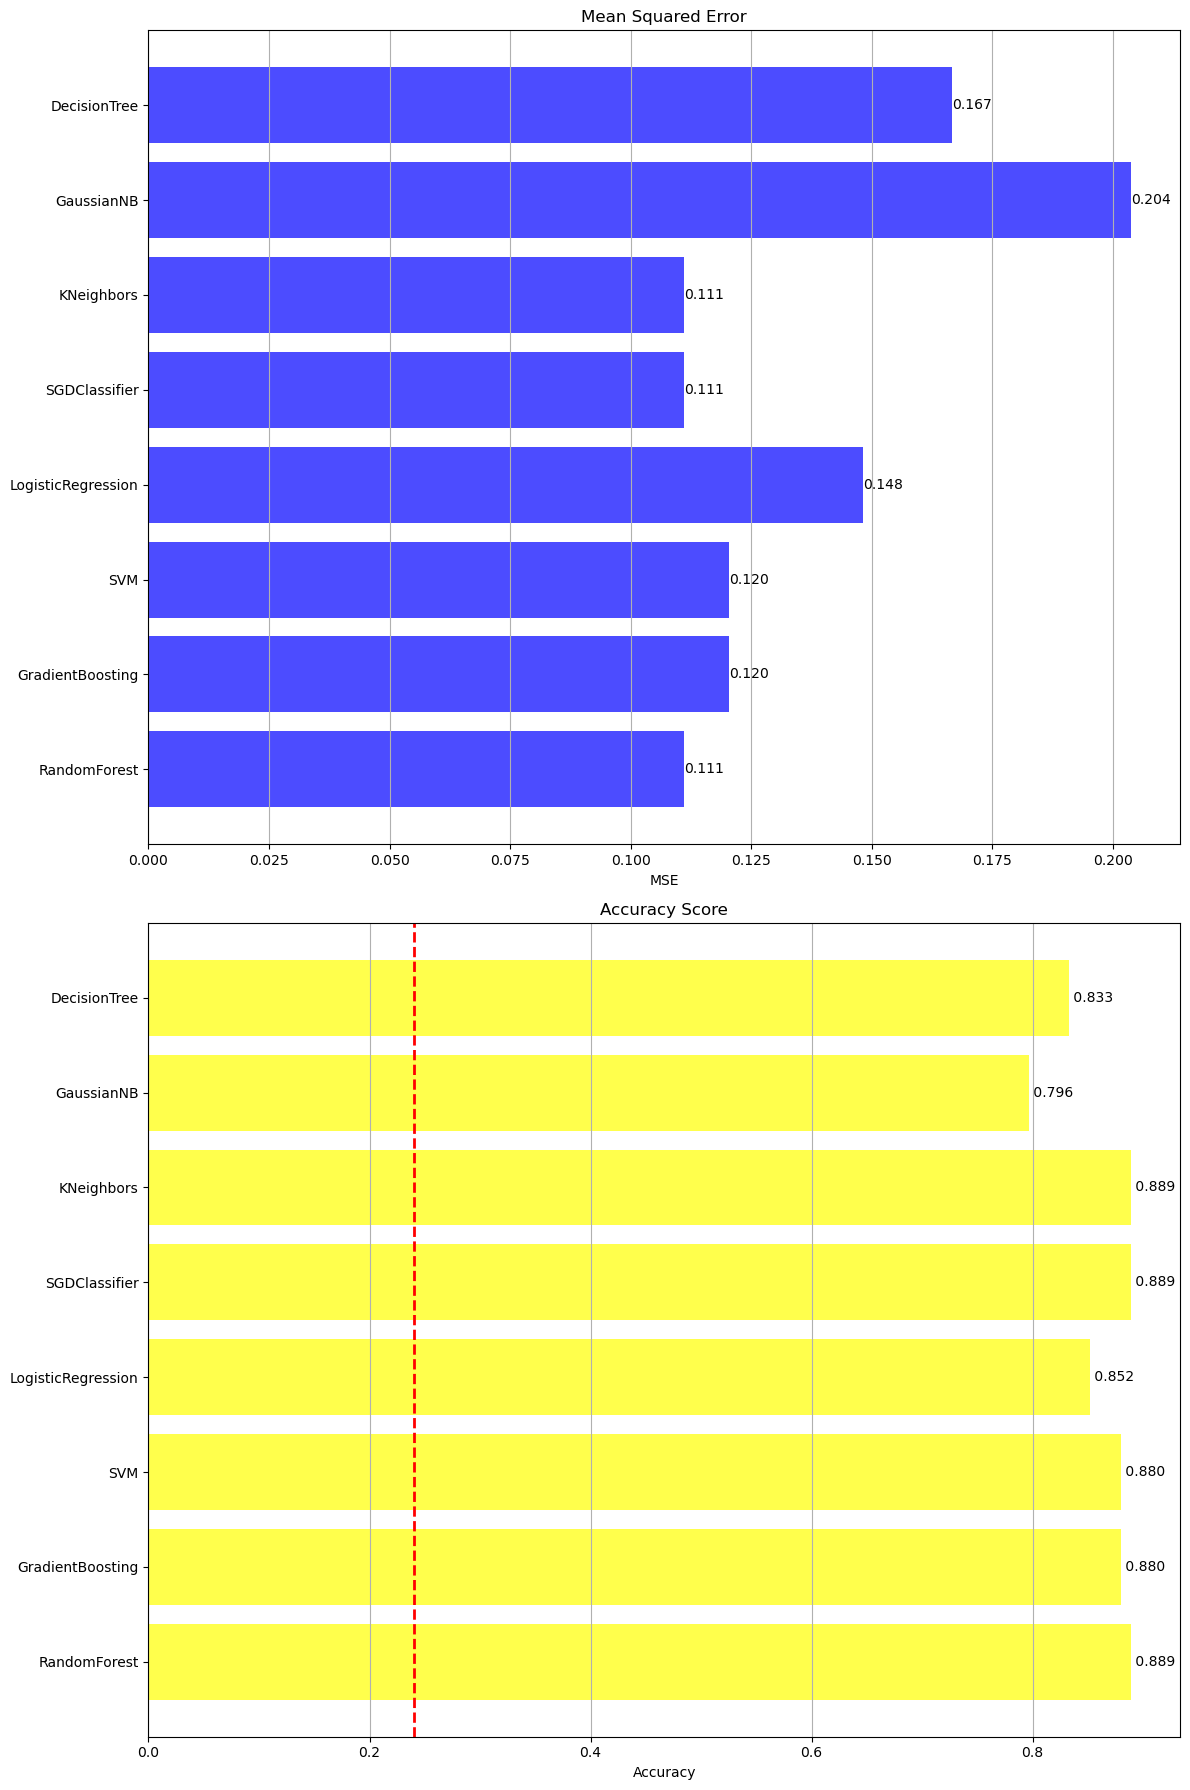

In [513]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 18))

for model, metrics in results.items():
    ax1.barh(model, metrics['mse'], color = 'blue', alpha = 0.7)
    ax1.text(metrics['mse'], model, f"{metrics['mse']:.3f}", va = 'center')
    ax2.barh(model, metrics['accuracy'], color = 'yellow', alpha = 0.7)
    ax2.text(metrics['accuracy'], model, f"{metrics['accuracy']: .3f}", va = 'center')



ax1.set_title('Mean Squared Error')
ax1.set_xlabel('MSE')
ax1.xaxis.grid(True)

ax2.set_title('Accuracy Score')
ax2.set_xlabel('Accuracy')
ax2.axvline(x = 0.24, color = 'red', linestyle = '--', linewidth = 2)
ax2.xaxis.grid(True)

plt.tight_layout()
plt.savefig('X.png')
plt.show()

# 7. Deep Learning Model Formation & Check Accuracy

In [753]:
from tensorflow.keras import regularizers

# Setting same seed number
tf.random.set_seed(42)

# Model define
model = keras.Sequential([
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01), input_shape = (X_train.shape[1],)),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),  
    layers.Dense(1, activation='sigmoid')
])

# Model Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_92 (Dense)                │ (None, 128)            │       102,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,769 (440.50 KB)

 Trainable params: 112,769 (440.50 KB)

 Non-trainable params: 0 (0.00 B)

In [754]:
# Early Stopping 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [755]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Best model save
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# Model FIT
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, checkpoint_callback])

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6250 - loss: 4.291 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7102 - loss: 4.1059 - val_accuracy: 0.8611 - val_loss: 3.7076
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7812 - loss: 3.802 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8631 - loss: 3.6396 - val_accuracy: 0.8426 - val_loss: 3.4840
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8438 - loss: 3.520 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8836 - loss: 3.3615 - val_accuracy: 0.9074 - val_loss: 3.1995
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7812 - loss: 3.279 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8584 - loss: 3.1066 - val_accuracy: 0.8056 - val_loss: 3.0630
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8125 - loss: 3.004 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8623 - loss: 2.8740 - val_accuracy: 0.8796 - val_loss: 2.7693
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1

## Deep Learning Model Results

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9062 - loss: 3.22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9061 - loss: 3.3051  
Test Accuracy of the Best Model: 0.8981
Test loss of the Best Model :  3.3328


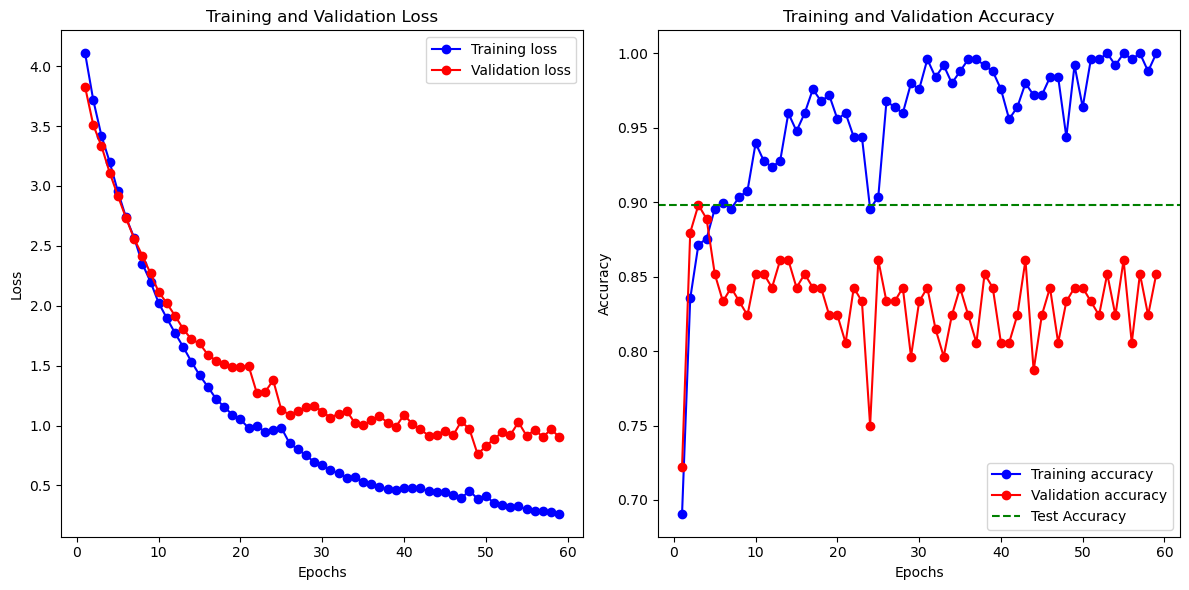

In [703]:
# Save Best Model
best_model = keras.models.load_model('best_model.keras')

# Test data evaluation
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print(f'Test Accuracy of the Best Model: {test_accuracy:.4f}')
print(f'Test loss of the Best Model : {test_loss: .4f}')

# Assesment scores
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# plotting
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('Deep learning results.png')
plt.show()

# 8. Prediction with validation dataset

In [756]:
# Load best deep learning model & validation
y_pred_prob = best_model.predict(x_val_df)

# prediction rate cutoff x > 0.5 : 1
y_pred = (y_pred_prob > 0.5).astype(int)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [757]:
# Check location of DNA Damage High Labeld Data
np.where(y_pred != 0)

(array([124, 126, 129, 167, 269, 285], dtype=int64),
 array([0, 0, 0, 0, 0, 0], dtype=int64))

In [763]:
# Find Near Data
from sklearn.neighbors import NearestNeighbors

# Choose specific data
specific_data = x_val_df.iloc[[167], :] 

# NearestNeighbors
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(x_val_df)
distances, indices = nbrs.kneighbors(specific_data)

closet_data = x_val_df.iloc[indices[0]]


print(f'Selected Data Index: {specific_data.index[0]}')
print(f'Closest 5 Data Indices: {closet_data.index.tolist()}')

for idx in closet_data.index.tolist():
    value = x_val_meta.loc[idx, 'Metadata_broad_sample']
    print(chem_dat[chem_dat['BROAD_ID'] == value]['CPD_NAME'].tolist()) # 64 DMSO

Selected Data Index: 167
Closest 5 Data Indices: [167, 89, 50, 168, 314]
['butylparaben']
['tyrphostin AG 82']
['succinylsulfathiazole']
['rotenone']
['SB-221284']
